In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats
import processing

### Log data

In [2]:
%%time
log_sample = pd.read_csv('./data/log_sample.csv')

CPU times: user 3.47 s, sys: 417 ms, total: 3.89 s
Wall time: 4.04 s


In [3]:
%%time
log_sample = processing.get_participants_for_log(log_sample)

CPU times: user 4.09 s, sys: 1.22 s, total: 5.31 s
Wall time: 5.56 s


In [4]:
np.random.seed(42)
log_sample = log_sample.loc[log_sample.participant_id.isin(
    np.random.choice(log_sample.participant_id.unique(),2000,replace=False)
)]

In [5]:
log_sample.shape

(1437302, 10)

In [6]:
%%time
log = processing.log_process(log_sample)

CPU times: user 32.9 s, sys: 1.15 s, total: 34.1 s
Wall time: 35.2 s


In [10]:
%%time
log = processing.mark_entries(log)

CPU times: user 43.7 s, sys: 377 ms, total: 44 s
Wall time: 44.2 s


In [8]:
from importlib import reload

In [9]:
reload(processing)

<module 'processing' from '/Users/itto/Documents/projects/typing/typing_automation/processing.py'>

In [11]:
log['iki_norm'] = log.iki / log.key.str.len()

In [29]:
# Find the weird multichar behaviour
# Action of an entry is single letter AND following two actions in the entry have increasing # of chars
mask = log.key.str.len() == 1
mask &= log.key.shift(-1).str.len() == 2
mask &= log.key.shift(-2).str.len() == 3
mask &= log.entry_id.shift(-1) == log.entry_id
mask &= log.entry_id.shift(-2) == log.entry_id.shift(-1)

participants_invalid = log.loc[mask].participant_id.unique()
log = log.loc[~log.participant_id.isin(participants_invalid)]

In [31]:
%%time
log = processing.infer_ite(log)

CPU times: user 4.39 s, sys: 230 ms, total: 4.62 s
Wall time: 4.64 s


1. Letters are not showing up in the log (e.g. ts_id == 14038)
1. People erasing from the current word into the previous word --> Count number of spaces in the text_field?
1. Improper ite detection because it's no longer the last action of an entry

So far, what seems to work really well for entry marking is to look at the number of spaces in the text_field. This way, as a user backspaces into the previous word, the entry_id goes backward as well. Question: how does this behave with middle-of-the-sentence inputs? I think that if these inputs are correctly marked as not forward, then the entry ids will anyways be negative.

In [153]:
log.loc[(log.key.str.len() == 1) & (log.len_diff > 1)]

,ts_id,entry_id,key,lev_dist,text_field,participant_id,len_diff,iki,text_field_prev,is_rep,ite,is_forward,iki_norm,ite2
6,3091,0.0,s,1,freak s,790,2,530.0,freak,False,none,True,530.0,NA
400,3108,-1.0,,1,"Bob, I’ll pick San Diego as",790,2,236.0,"Bob, I’ll pick San Diego a",False,none,True,236.0,NA
3127,10053,4.0,f,1,I will handle this af,3050,2,722.0,I will handle this,False,none,True,722.0,NA
4605,14027,3.0,p,1,Please set something up,4168,2,1057.0,Please set something,False,none,True,1057.0,NA
4763,14038,5.0,r,1,If so he pr,4168,2,1201.0,If so he,False,none,True,1201.0,NA
5876,15761,2.0,a,1,It wa,4772,2,720.0,It,False,none,True,720.0,NA
9083,23558,4.0,t,1,Do you need to be t,7286,2,588.0,Do you need to be,False,none,True,588.0,NA
9121,23561,0.0,s,1,His,7286,2,361.0,H,False,none,True,361.0,NA
9200,23564,-3.0,_,28,Samantha would need around -,7286,28,478.0,,False,none,False,478.0,NA
9854,24395,0.0,m,2,I'm,7465,2,930.0,I,False,none,True,930.0,NA


### ITE 2

In [680]:
# Default null
log['ite2'] = None
# Default for predict is none
log.loc[log.ite == 'predict','ite2'] = 'none'

# Prediction: The ITE action is the only action in the entry AND is new word
mask = log.ite == 'predict'
mask &= log.entry_id != log.entry_id.shift(-1)
mask &= log.entry_id != log.entry_id.shift(1)
mask &= log.text_field.shift(1).str[-1] == ' '
log.loc[mask,'ite2'] = 'prediction'

# Correction: Not pure forward motion AND mutliple actions in the entry
mask = log.ite == 'predict'
mask &= log.len_diff != log.lev_dist
mask &= log.entry_id == log.entry_id.shift(1)
log.loc[mask,'ite2'] = 'correction'

# Correction 2: Preceded by backspace AND not a new word
mask = log.ite == 'predict'
mask &= log.key.shift(1) == '_'
mask &= log.text_field.shift(1).str[-1] != ' '
log.loc[mask,'ite2'] = 'correction2'

# Completion: Pure forward motion AND mutliple actions in the entry
mask = log.ite == 'predict'
mask &= log.len_diff == log.lev_dist
mask &= log.entry_id == log.entry_id.shift(1)
log.loc[mask,'ite2'] = 'completion'


### Words

In [703]:
groupby = log.loc[log.entry_id >= 0].groupby([
    'participant_id',
    'ts_id',
    'entry_id'
])

words = groupby.last().text_field.str.split(' ').str[-1]
words = words.to_frame('word')
# Look two spaces back for keys ending with a space
mask = groupby.last().key.str[-1] == ' '
words.loc[mask,'word'] = groupby.last().loc[mask].text_field.str.split(' ').str[-2]

        
groupby = log.loc[(log.entry_id >= 0) & (log.ite != 'none')].groupby([
    'participant_id',
    'ts_id',
    'entry_id'
])

words['ite'] = groupby.last().ite
words.ite.fillna('none',inplace=True)

words['ite2'] = groupby.last().ite2

words['ite_input'] = groupby.last().key

words['ite_input_prev'] = groupby.last().text_field_prev.str.split(' ').str[-1]

words['ite_lev_dist'] = groupby.last().lev_dist

words['ite_len_diff'] = groupby.last().len_diff

words.reset_index(inplace=True)
words['word_length'] = words.word.str.len()

In [704]:
words.ite.value_counts(normalize=True)

none        0.877717
autocorr    0.072030
predict     0.044008
swype       0.006245
Name: ite, dtype: float64

In [705]:
words.ite2.value_counts(normalize=True)

completion     0.713020
correction     0.259198
none           0.017720
correction2    0.009010
prediction     0.001051
Name: ite2, dtype: float64

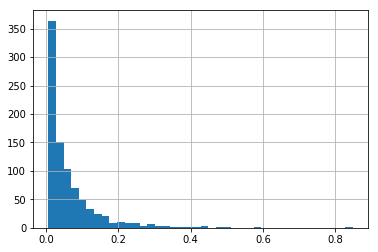

In [684]:
words.groupby('participant_id').ite.value_counts(normalize=True).unstack()['predict'].hist(bins=40)

### Word frequency

In [706]:
# https://www.wordfrequency.info/free.asp
word_freq = pd.read_csv('./word_frequency.csv',sep='\t')

In [707]:
word_freq.Word = word_freq.Word.str.strip()

In [708]:
word_freq.drop_duplicates('Word',keep='first',inplace=True)

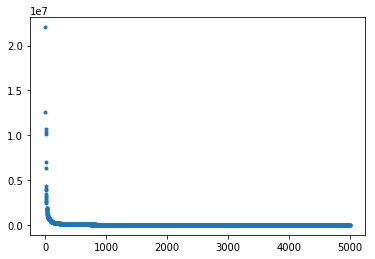

In [709]:
word_freq.Frequency.plot(style='.')

In [710]:
freq_map = word_freq.set_index('Word').Frequency
words['frequency'] = words.word.str.lower().map(freq_map).fillna(0)
words.loc[(words.frequency < 60000) & (words.frequency > 0),'freq_category'] = 'common'
words.loc[(words.frequency > 60000),'freq_category'] = 'very_common'
words.loc[(words.frequency == 0),'freq_category'] = 'uncommon'
words.loc[words.word.str.contains("'"),'freq_category'] = 'conjunction'

## Global analysis

Let's look at some general characteristics of prediction usage

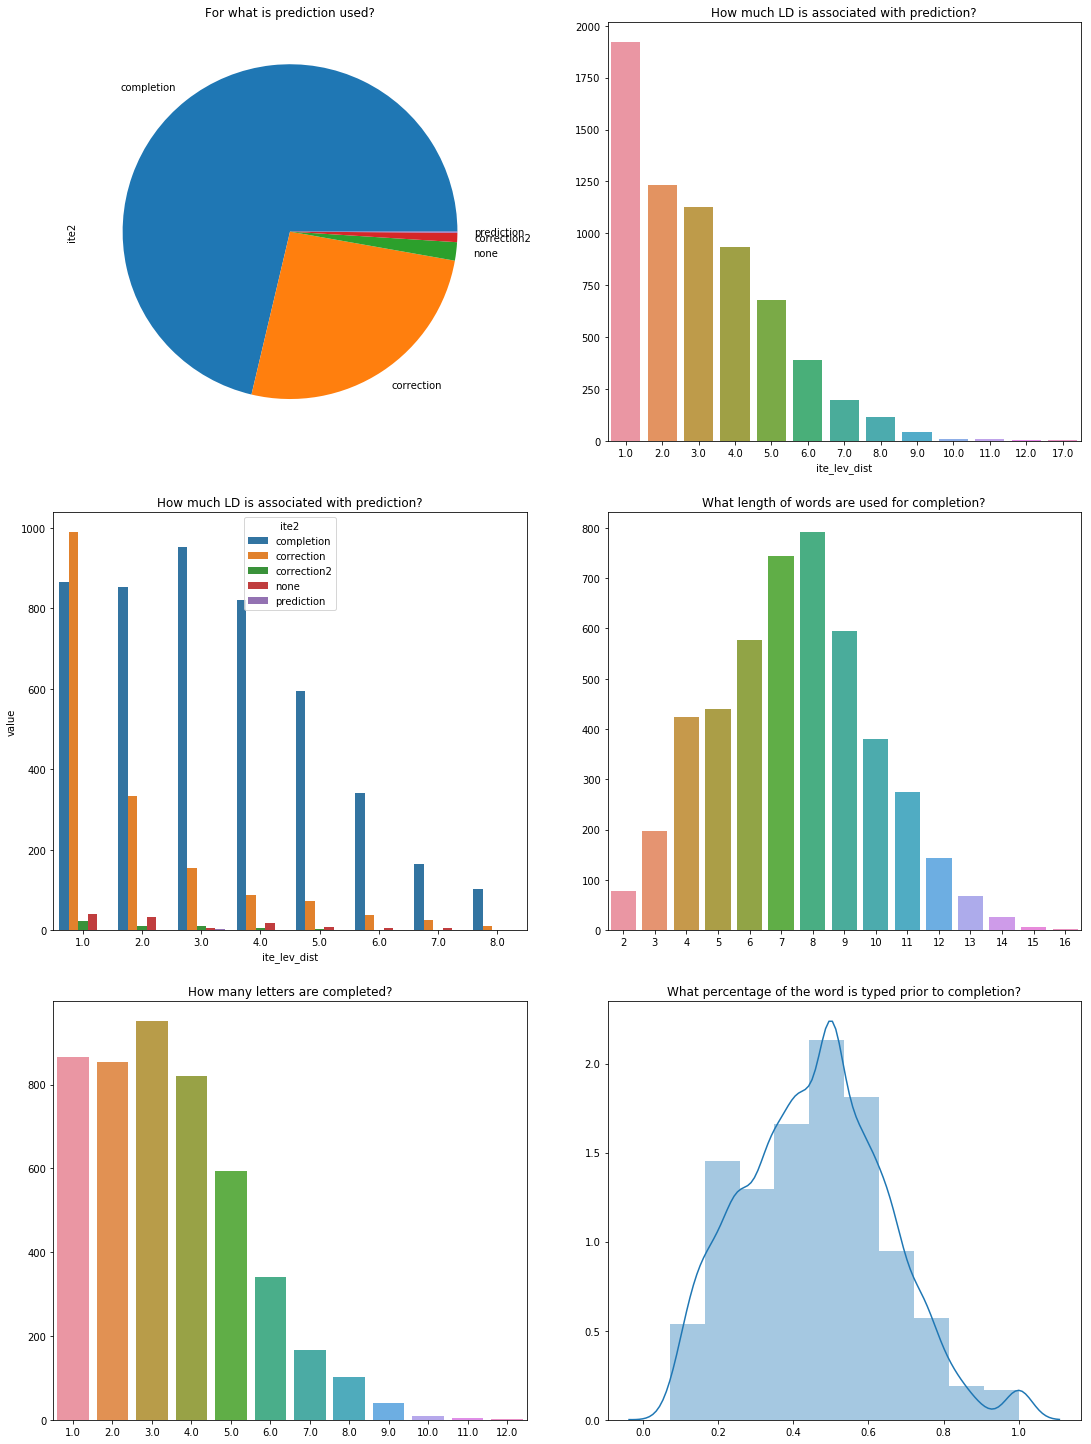

In [692]:
f,ax = plt.subplots(3,2,figsize=(15,20))
ax1,ax2,ax3,ax4,ax5,ax6=ax.flatten()

f.tight_layout(w_pad=5,h_pad=5)

ax1.set_title('For what is prediction used?')
data = words.loc[words.ite == 'predict']
data.ite2.value_counts(normalize=True).plot.pie(ax=ax1)
ax1.set_aspect('equal')

ax2.set_title('How much LD is associated with prediction?')
data = words.loc[words.ite == 'predict']
data = data.groupby('ite_lev_dist').size()
sns.barplot(data.index,data.values,ax=ax2)

ax3.set_title('How much LD is associated with prediction?')
data = words.loc[words.ite == 'predict']
data = data.loc[data.ite_lev_dist < 9]
data = data.groupby(['ite_lev_dist','ite2']).size().unstack().reset_index().melt('ite_lev_dist')
sns.barplot(data.ite_lev_dist,data.value,hue=data.ite2,ax=ax3)

ax4.set_title('What length of words are used for completion?')
data = words.loc[words.ite2 == 'completion']
data = data.ite_input.str.len().value_counts()
sns.barplot(data.index,data.values,ax=ax4)

ax5.set_title('How many letters are completed?')
data = words.loc[words.ite2 == 'completion']
data = data.ite_lev_dist.value_counts()
sns.barplot(data.index,data.values,ax=ax5)

ax6.set_title('What percentage of the word is typed prior to completion?')
data = words.loc[words.ite2 == 'completion']
data = (data.ite_lev_dist/data.ite_input.str.len())
sns.distplot(data,bins=10,ax=ax6)

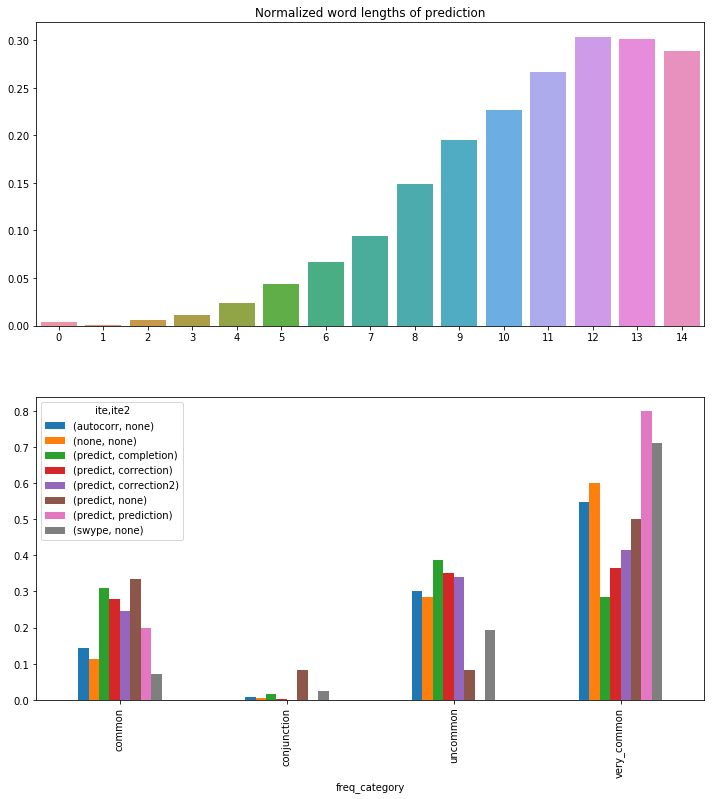

In [693]:
f,ax = plt.subplots(2,1,figsize=(10,10))
ax1,ax2 =ax.flatten()

f.tight_layout(w_pad=5,h_pad=5)

ax1.set_title('Normalized word lengths of prediction')
data1 = words.loc[words.word.str.len() < 15]
data2 = data1.loc[data1.ite == 'predict']
data = (data2.word.str.len().value_counts() / data1.word.str.len().value_counts())
sns.barplot(data.index,data.values,ax=ax1)

ax2.set_title('')
data = words.loc[(words.ite == 'none') | (words.word == words.ite_input)]
data.groupby(['ite','ite2']).freq_category.value_counts(normalize=True).unstack().T.plot.bar(ax=ax2)

In [711]:
data = words.loc[words.ite2 == 'completion']
section1 = data.ite_input.str.len()
section2 = data.ite_lev_dist
matrix1 = data.groupby([section1,section2]).size().unstack().fillna(0)

# Normalize rows
matrix2 = matrix1.div(matrix1.sum(axis=1),axis=0)

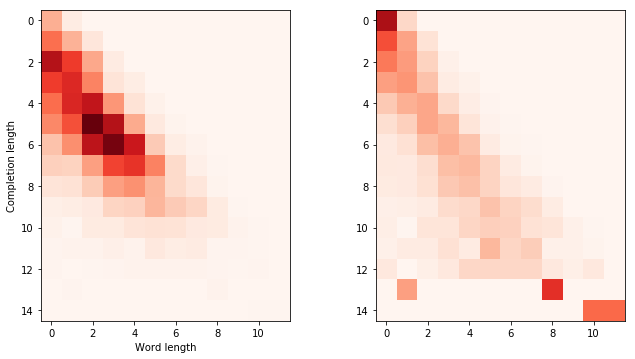

In [712]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
f.tight_layout(pad=5)

im1 = ax1.imshow(matrix1,cmap='Reds')
ax1.set_xlabel('Word length')
ax1.set_ylabel('Completion length')
im2 = ax2.imshow(matrix2,cmap='Reds',vmax=1)

## Participant analysis

### Participants

In [713]:
participants = pd.DataFrame()
participants['id'] = words.participant_id.unique()
participants.set_index('id',inplace=True)
participants['n_words'] = words.groupby(['participant_id']).size()
participants['n_predict'] = words.groupby(['participant_id','ite']).size().unstack()['predict'].fillna(0)
participants['n_autocorr'] = words.groupby(['participant_id','ite']).size().unstack()['autocorr'].fillna(0)

# Rate of ite usage
participants_ite = words.groupby('participant_id').ite.value_counts(normalize=True).unstack()
participants_ite.fillna(0,inplace=True)

# Rate of ite2
participants_ite2 = words.groupby('participant_id').ite2.value_counts(normalize=True).unstack()
participants_ite2.fillna(0,inplace=True)

# Rate of word frequency
data1 = words.groupby(['participant_id','ite']).freq_category.value_counts(normalize=True).unstack()
data2 = words.groupby('participant_id').freq_category.value_counts(normalize=True).unstack()
participants_freq = data1.reset_index(level=1).fillna(0)
participants_freq_relative = (data1 / data2).reset_index(level=1).fillna(0)

# Word length
participants_len = words.groupby(['participant_id','ite']).word_length.median().unstack().fillna(0)['predict']

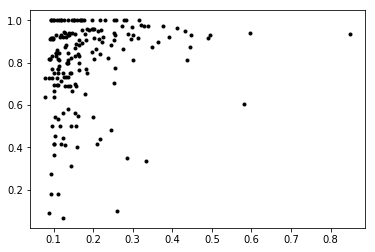

In [740]:
mask = participants.n_predict > 10
plt.plot(
    participants_ite.loc[mask].predict,
    participants_ite2.loc[mask].completion,
    'k.'
)

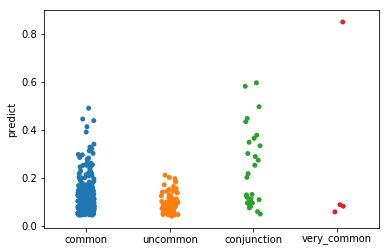

In [715]:
mask = participants.n_predict > 5
pref = participants_freq_relative.groupby('ite').idxmax(axis=1).loc['predict']
sns.stripplot(pref.loc[mask],participants_ite.loc[mask].predict)

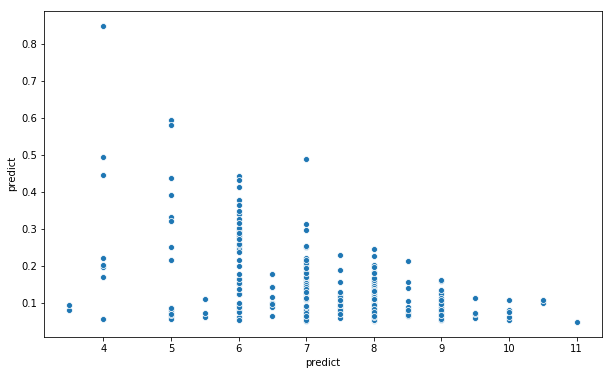

In [726]:
f,ax = plt.subplots(1,1,figsize=(10,6))

mask = participants.n_predict > 6
pref = participants_len
sns.scatterplot(
    pref.loc[mask],
    participants_ite.loc[mask].predict,
)

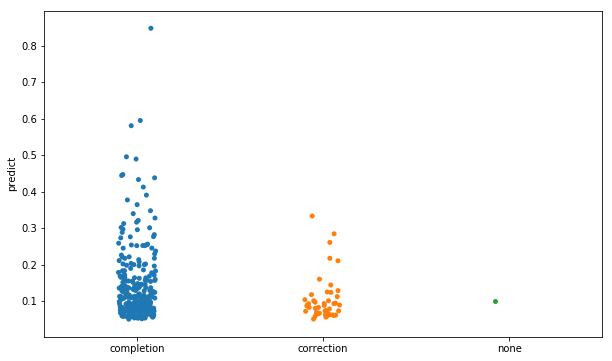

In [737]:
f,ax = plt.subplots(1,1,figsize=(10,6))

mask = participants.n_predict > 6
pref = participants_ite2.loc[mask].idxmax(axis=1)
sns.stripplot(
    pref,
    participants_ite.loc[mask].predict
)

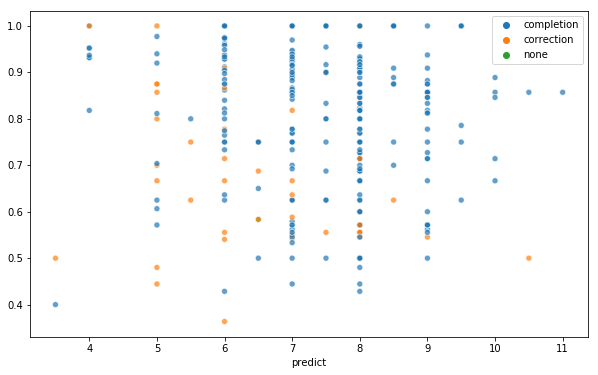

In [738]:
f,ax = plt.subplots(1,1,figsize=(10,6))

mask = participants.n_predict > 6
pref = participants_len
sns.scatterplot(
    pref.loc[mask],
    participants_ite2.loc[mask].max(axis=1),
    hue = participants_ite2.loc[mask].idxmax(axis=1),
    alpha=0.7
)

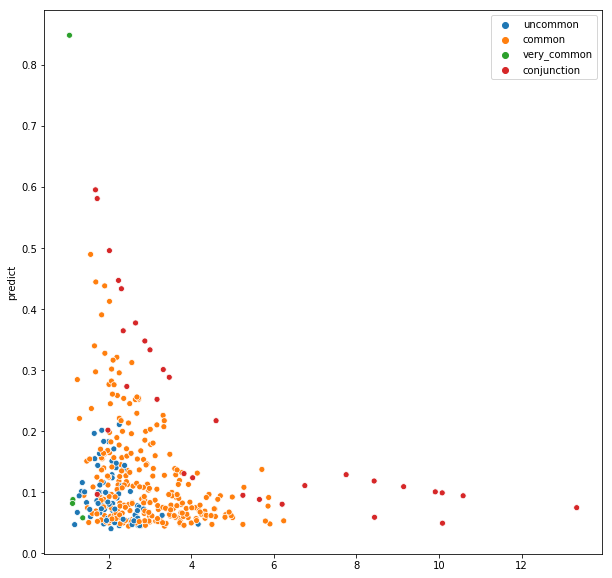

In [717]:
f,ax = plt.subplots(1,1,figsize=(10,10))
mask = participants.n_predict > 5
data = participants_freq_relative.loc[participants_freq.ite == 'predict']
pref = data.max(axis=1)
sns.scatterplot(
    pref.loc[mask],
    participants_ite.loc[mask].predict,
    hue=data.drop('ite',axis=1).idxmax(axis=1),
    ax=ax
)

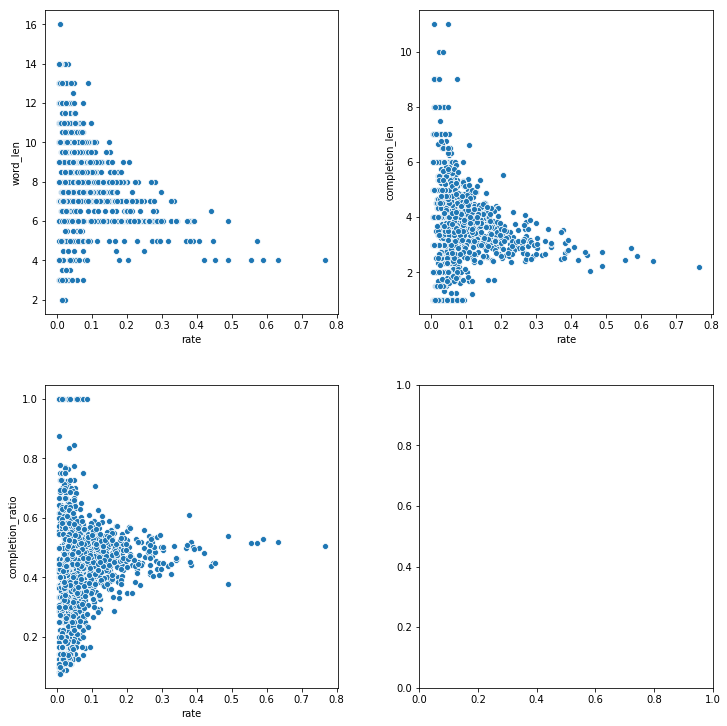

In [24]:
f,ax = plt.subplots(2,2,figsize = (10,10))
f.tight_layout(w_pad=5,h_pad=5)

ax1,ax2,ax3,ax4=ax.flatten()

tmp = log.loc[log.ite2 == 'completion'].copy()
tmp['word_len'] = tmp.key.str.len()
tmp['completion_len'] = tmp.lev_dist
tmp['completion_ratio'] = tmp.completion_len/tmp.word_len

data = tmp.groupby('participant_id').word_len.median().to_frame('word_len')
data['completion_len'] = tmp.groupby('participant_id').completion_len.mean()
data['completion_ratio'] = tmp.groupby('participant_id').completion_ratio.mean()
data['rate'] = participants.rate_predict

sns.scatterplot(data.rate,data.word_len,data=data,ax=ax1)
sns.scatterplot(data.rate,data.completion_len,data=data,ax=ax2)
sns.scatterplot(data.rate,data.completion_ratio,data=data,ax=ax3)

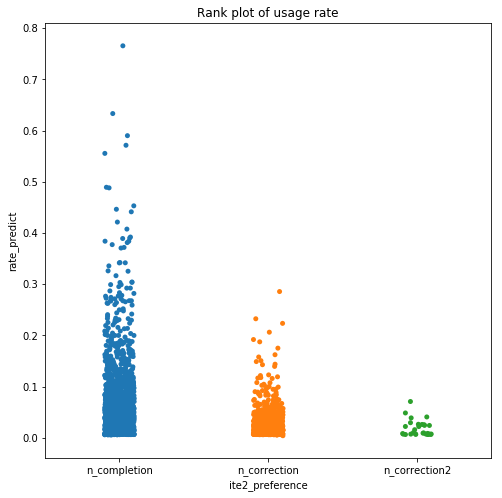

In [25]:
%matplotlib inline

f,ax = plt.subplots(1,1,figsize=(8,8))

ax.set_title('Rank plot of usage rate')
data = participants.loc[participants.n_predict > 0].copy()
data['ite2_preference'] = data[['n_completion','n_correction','n_correction2']].idxmax(axis=1)
data.loc[data.n_predict == 0,'ite2_preference'] = 'none'

sns.stripplot(x = data.ite2_preference, y = data.rate_predict)

<IPython.core.display.Javascript object>


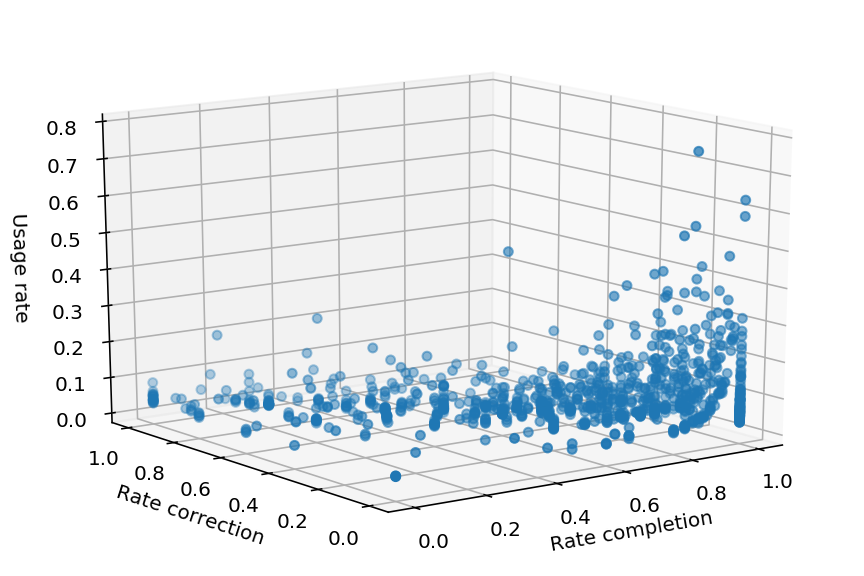

In [27]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

fig = plt.figure()
ax = Axes3D(fig)

data = participants.loc[participants.n_predict > 4].copy()
ax.scatter(data.rate_completion, data.rate_correction, data.rate_predict)
ax.set_xlabel('Rate completion')
ax.set_ylabel('Rate correction')
ax.set_zlabel('Usage rate')
plt.show()

### Autocorrect and Prediction

(-0.03904806365688786,
 0.8046730636568878,
 -0.023716558264289762,
 0.49285236073342553)

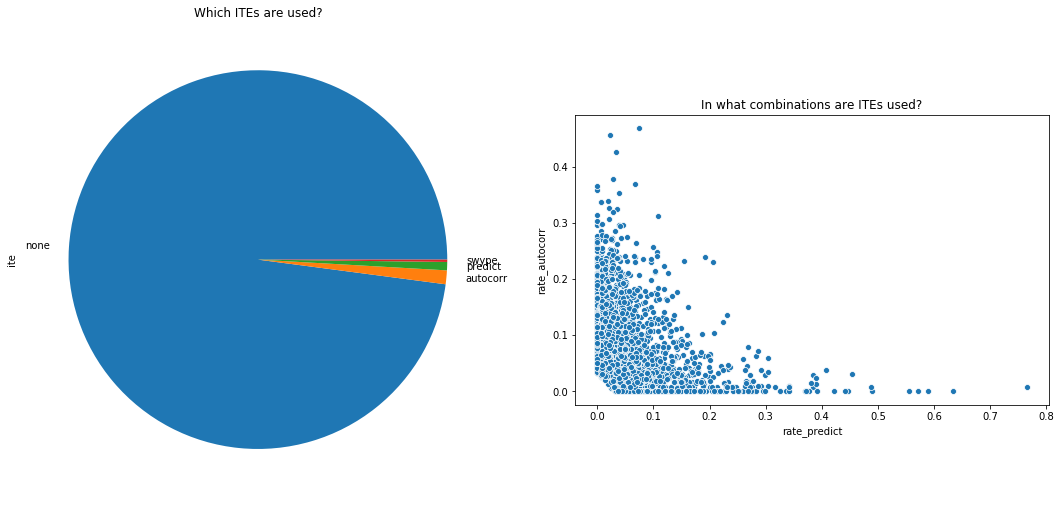

In [28]:
%matplotlib inline

f,ax = plt.subplots(1,2,figsize=(15,20))
ax1,ax2 = ax.flatten()

f.tight_layout(w_pad=5,h_pad=5)

ax1.set_title('Which ITEs are used?')
log.ite.value_counts(normalize=True).plot.pie(ax=ax1)
ax1.set_aspect('equal')

ax2.set_title('In what combinations are ITEs used?')
data = participants.loc[participants.n_predict + participants.n_autocorr >= 5]
sns.scatterplot(data.rate_predict,data.rate_autocorr,ax=ax2)
ax2.axis('scaled')

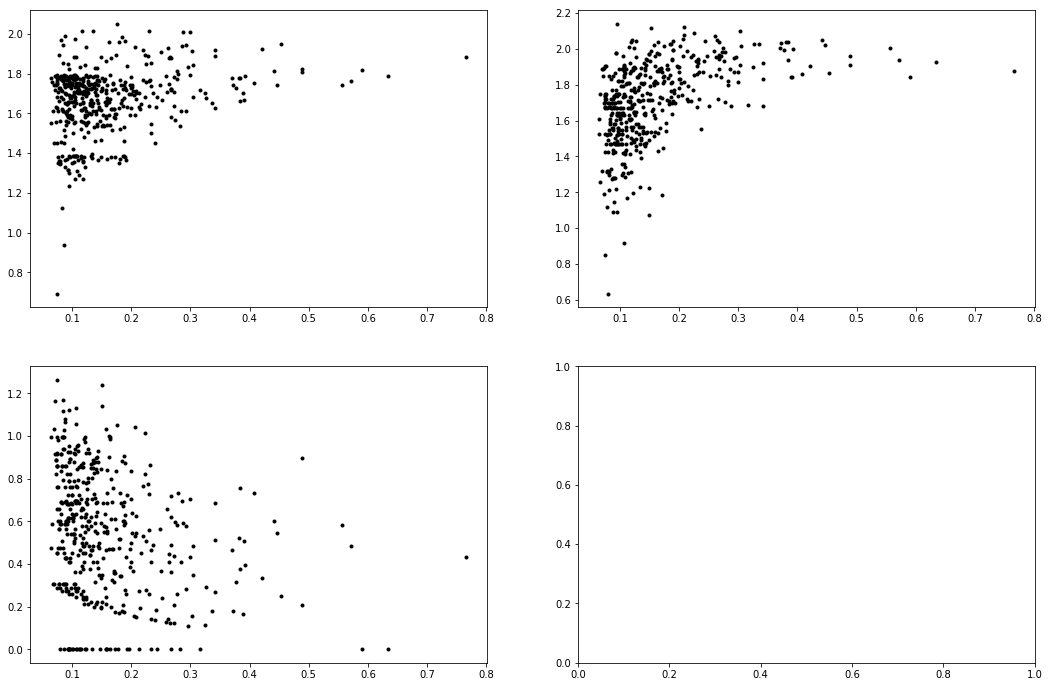

In [277]:
%matplotlib inline
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(18,12))

data = participants.loc[participants.n_predict > 10].copy()

entropy_freq = data[[
    'rate_conjunction',
    'rate_uncommon',
    'rate_common',
    'rate_very_common'
]].apply(stats.entropy,axis=1)

log['key_len'] = log.key.str.len()
mask = (log.ite == 'predict') & (log.key_len <= 10) & (log.participant_id.isin(data.index.unique()))
entropy_len = log.loc[mask].groupby(['participant_id']).key_len.value_counts(normalize=True).unstack().fillna(0)
entropy_len = entropy_len.apply(stats.entropy,axis=1)
log.drop('key_len',axis=1,inplace=True)


entropy_ite2 = data[[
    'rate_completion',
    'rate_correction',
    'rate_correction2',
    'rate_none'
]].apply(stats.entropy,axis=1)

ax1.plot(data.rate_predict,entropy_freq,'k.')
ax2.plot(data.rate_predict,entropy_len,'k.')
ax3.plot(data.rate_predict,entropy_ite2,'k.')

<IPython.core.display.Javascript object>


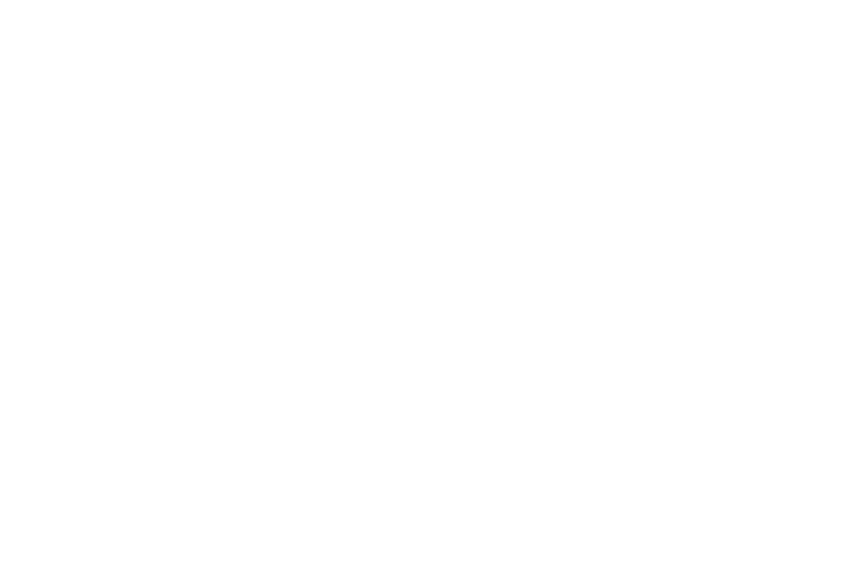

<IPython.core.display.Javascript object>


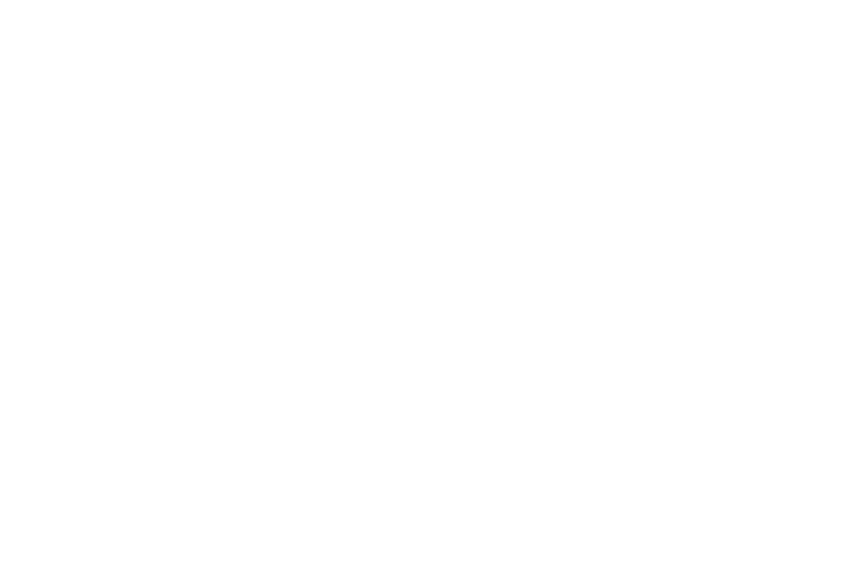

In [262]:
from importlib import reload
reload(plt)
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(entropy_freq, entropy_len, entropy_ite2)
ax.set_xlabel('Rate common')
ax.set_ylabel('Rate very common')
ax.set_zlabel('Rate conjunction')
plt.show()

## Performance

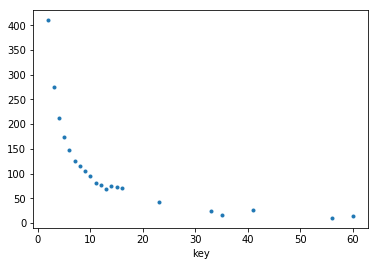

In [77]:
data = log.loc[log.ite == 'predict']
data.groupby(data.key.str.len()).iki_norm.median().plot(style='.')

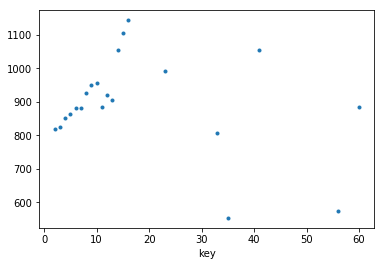

In [78]:
data.groupby(data.key.str.len()).iki.median().plot(style='.')

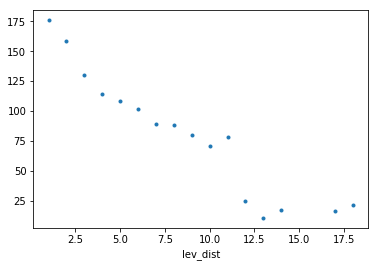

In [290]:
data.groupby('lev_dist').iki_norm.median().plot(style='.')

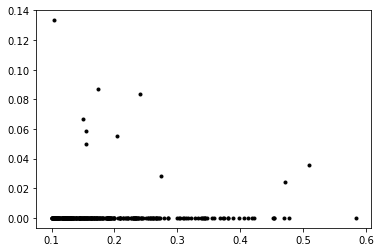

In [283]:
data = participants.loc[participants.rate_predict >= 0.1]
plt.plot(data.rate_predict,data.rate_prediction,'k.')

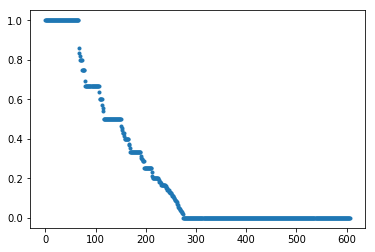

In [231]:
participants.rate_correction.sort_values(ascending=False).reset_index(drop=True).plot(style='.')

In [162]:
participants.loc[participants.rate_correction2 == 1].n_predict.max()

1.0

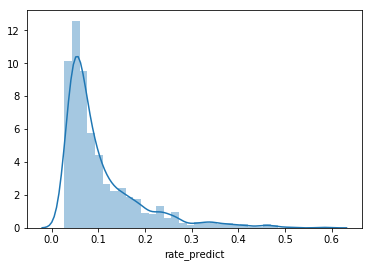

In [297]:
data = participants.loc[participants.n_predict >= 5]
sns.distplot(data.rate_predict)

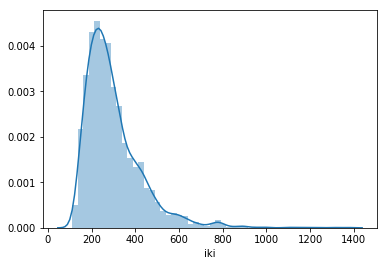

In [343]:
sns.distplot(log.loc[log.entry_id >= 0].groupby('participant_id').iki.mean())

In [352]:
participants = pd.merge(
    participants,
    log.loc[log.entry_id >= 0].groupby('participant_id').iki.mean().to_frame('speed'),
    left_index = True, right_index = True
)

In [401]:
participants.speed = 1000/participants.speed

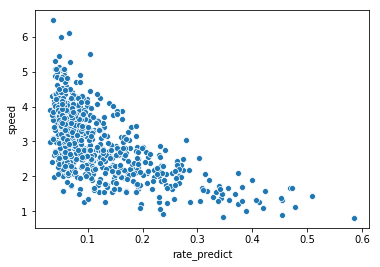

In [405]:
data = participants.loc[(participants.n_predict > 5)]
sns.scatterplot(data.rate_predict,data.speed)

In [406]:
participants_full = pd.merge(processing.get_participants(),participants,left_on='PARTICIPANT_ID',right_index=True)

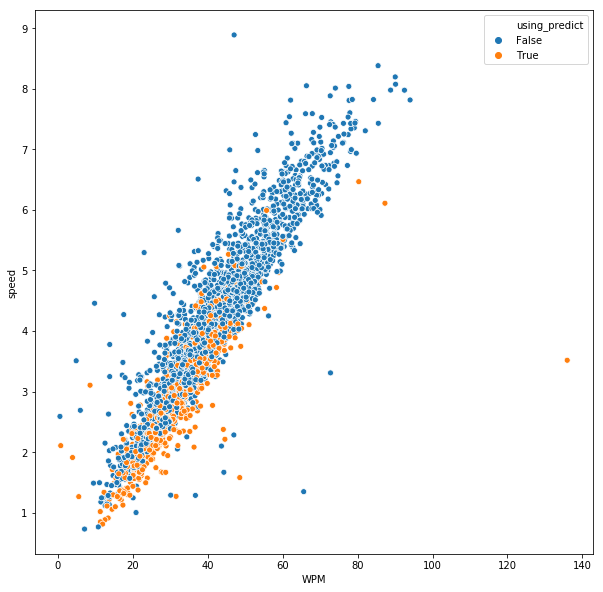

In [413]:
participants_full['using_predict'] = participants_full.n_predict > 5
f,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(participants_full.WPM,participants_full.speed,hue=participants_full.using_predict)

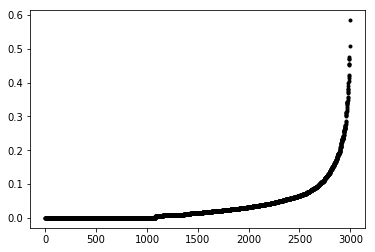

In [432]:
plt.plot(participants_full.rate_predict.sort_values().reset_index(drop=True),'k.')

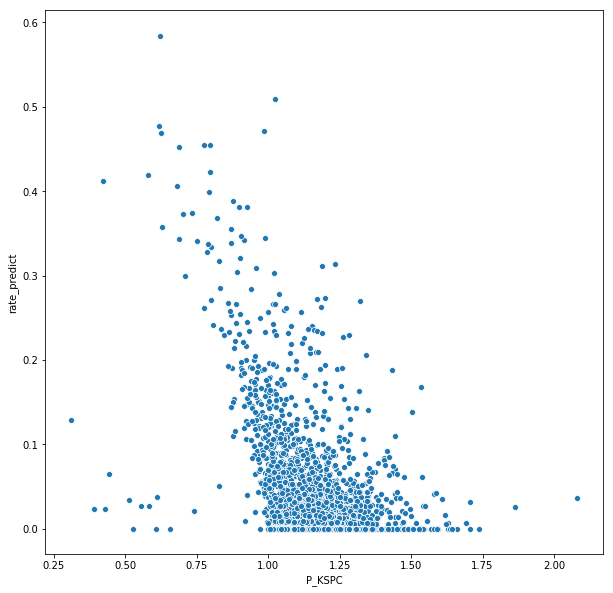

In [430]:
data = participants_full.loc[participants_full.n_predict > -1]
f,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data.P_KSPC,data.rate_predict)

In [374]:
log.loc[log.entry_id >= 0].groupby(['participant_id','entry_id']).first()

ts_id             key  \
participant_id entry_id                            
827            0.0          3254               I   
               1.0          3254               m   
               2.0          3254               t   
               3.0          3254               t   
               4.0          3254               a   
               5.0          3254               e   
               6.0          3254               n   
               7.0          3254               t   
               8.0          3254               r   
               9.0          3260               e   
               10.0         3260               t   
               11.0         3260               m   
               12.0         3275               O   
               13.0         3282               R   
1417           0.0          4769               I   
               1.0          4769               r   
               2.0          4769               j   
               3.0          4769               r   
               4.0          4769               t   
               5.0          4777               D   
               6.0          4769               c   
               7.0          4782               h   
               8.0          4782               c   
               9.0          4769  technicalities   
               10.0         4788               t   
               11.0         4788               p   
               12.0         4821               c   
               13.0         4821               m   
               14.0         4802               h   
               15.0         4802               a   
...                          ...             ...   
273960         9.0       1809991               a   
               10.0      1809883               3   
               11.0      1809883               e   
               12.0      1809839               o   
               13.0      1809839               t   
               14.0      1809839               c   
               15.0      1809839               a   
               16.0      1809839               t   
               17.0      1809839               t   
               18.0      1809839               g   
               19.0      1809839               a   
               20.0      1809839               l   
               21.0      1809839               q   
               22.0      1809839               y   
274091         0.0       1811058               M   
               1.0       1811058               c   
               2.0       1811058               h   
               3.0       1811058               u   
               4.0       1811058               h   
               5.0       1811058               F   
               6.0       1811058               e   
               7.0       1811067               a   
               8.0       1811074               f   
               9.0       1811074               w   
               10.0      1811074               J   
               11.0      1811074               0   
               14.0      1811074               a   
               15.0      1811074               e   
               16.0      1811074               y   
               17.0      1811074               t   

                                                                text_field  \
participant_id entry_id                                                      
827            0.0                                                       I   
               1.0                                                     I m   
               2.0                                               I meant t   
               3.0                                            I meant to t   
               4.0                                        I meant to try a   
               5.0                                    I meant to try and e   
               6.0                           I meant to try and explain, n   
               7.0                       I meant

### Buglist

#### Two different predict backend behaviours

There are two predict backend behaviours. The first one will register the entire word as the key (e.g. 'guilty'), the second will only register the completed portion (e.g. 'lty'). We analyze assuming the first behaviour, but we should correct the second behaviour to be consistent. Otherwise, many mentrics are incorrecxt (e.g. the word length is currently measured by just taking the length of the key, since it 

In [163]:
mask = log.ite == 'predict'
mask &= (log.lev_dist == log.key.str.len())
log.loc[mask]

,ts_id,entry_id,key,text_field,lev_dist,len_diff,iki,text_field_prev,is_rep,ite,is_forward,participant_id,iki_norm,ite2
112217,152260,5.0,us,the injury is more serious,3,3,795.0,the injury is more serio,False,predict,True,41756,265.000000,completion
112232,152260,9.0,ers,the injury is more serious than. The Panthers,4,4,744.0,the injury is more serious than. The Panth,False,predict,True,41756,186.000000,completion
112293,152264,10.0,tion,I hope that you find these communication,5,5,688.0,I hope that you find these communica,False,predict,True,41756,137.600000,completion
112309,152264,14.0,e,I hope that you find these communications info...,2,2,861.0,I hope that you find these communications info...,False,predict,True,41756,430.500000,completion
112314,152264,19.0,e,I hope that you find these communications info...,2,2,1222.0,I hope that you find these communications info...,False,predict,True,41756,611.000000,correction2
112353,152272,8.0,utes,"We are delayed, got another 30 minutes",5,5,631.0,"We are delayed, got another 30 min",False,predict,True,41756,126.200000,completion
112419,152279,2.0,ng,It's going,3,3,568.0,It's goi,False,predict,True,41756,189.333333,completion
112434,152279,7.0,crous,It's going to be ludicrous,6,6,979.0,It's going to be ludi,False,predict,True,41756,163.166667,completion
114558,157252,10.0,7,We will have some good detail by January 7,2,2,1857.0,We will have some good detail by January,False,predict,True,42795,928.500000,none
194617,268379,4.0,up,this upgrade may take up,2,0,960.0,this upgrade may take ho,False,predict,True,70797,480.000000,correction


#### Multi-word inputs

Some a participants exhibit a keyboard behaviour where the key contains current and previous words that were entered. Is this due to buggy key inference? Or is this some sort of software behaviour? Check the raw data.

In [190]:
log.loc[(log.participant_id == 92275)].head(10)

,ts_id,entry_id,key,text_field,lev_dist,len_diff,iki,text_field_prev,is_rep,ite,is_forward,participant_id,iki_norm,ite2
370486,423413,0.0,I,I,67,-1,NaN,Don't use him this week.,False,none,True,92275,NaN,NaN
370487,423413,0.0,I,I,0,0,99.0,I,False,none,True,92275,99.000000,NaN
370488,423413,1.0,I sent,I sent,5,5,70.0,I,False,none,True,92275,11.666667,NaN
370489,423413,2.0,I sent it,I sent it,3,3,160.0,I sent,False,none,True,92275,17.777778,NaN
370490,423413,3.0,I sent it to,I sent it to,3,3,156.0,I sent it,False,none,True,92275,13.000000,NaN
370491,423413,4.0,I sent it to her,I sent it to her,4,4,273.0,I sent it to,False,none,True,92275,17.062500,NaN
370492,423413,5.0,I sent it to,I sent it to,4,-4,298.0,I sent it to her,False,none,True,92275,24.833333,NaN
370493,423413,-3.0,_,,17,-17,752.0,I sent it to her.,False,none,False,92275,752.000000,NaN
370494,423429,1.0,I thought,I thought,13,-1,NaN,I sent it to her.,False,swype,True,92275,NaN,NaN
370495,423429,2.0,I thought,I thought,0,0,172.0,I thought,False,none,True,92275,19.111111,NaN


In [191]:
log.loc[log.key.str.findall(' ').apply(len) >= 3].participant_id.value_counts().head(8)

92275     145
162141     51
42795      47
196274     31
102066      2
109046      1
211349      1
155534      1
Name: participant_id, dtype: int64

#### Repeated keys

Some participants using Swype will exhibit repeated keys (maybe due to the space added at the end of the word?). This results in double the Swype entries.

In [264]:
log.loc[log.ts_id == 267609].head(10)

,ts_id,entry_id,key,text_field,lev_dist,len_diff,iki,text_field_prev,is_rep,ite,is_forward,participant_id,iki_norm,ite2
192250,267609,0.0,I,I,32,-1,NaN,Let me know if I can be of help.,False,none,True,70607,NaN,NaN
192251,267609,0.0,I,I,0,0,178.0,I,False,none,True,70607,178.0,NaN
192252,267609,-1.0,,I,1,1,30.0,I,False,none,True,70607,30.0,NaN
192253,267609,1.0,just,I just,4,4,584.0,I,False,swype,True,70607,146.0,NaN
192254,267609,1.0,just,I just,0,0,240.0,I just,False,swype,True,70607,60.0,NaN
192255,267609,-1.0,,I just,1,1,22.0,I just,False,none,True,70607,22.0,NaN
192256,267609,2.0,t,I just t,1,1,15.0,I just,False,none,True,70607,15.0,NaN
192257,267609,2.0,r,I just tr,1,1,158.0,I just t,False,none,True,70607,158.0,NaN
192258,267609,2.0,a,I just tra,1,1,167.0,I just tr,False,none,True,70607,167.0,NaN
192259,267609,2.0,x,I just trax,1,1,582.0,I just tra,False,none,True,70607,582.0,NaN


In [235]:
log.loc[(log.key.str.strip(' ').str.len() > 1) & (log.key.shift(-1) == log.key)].participant_id.value_counts()

92275     107
240454     69
70633      60
70607      56
70623      37
187820     21
255734     13
158096      8
233180      8
89508       6
127510      6
146070      5
75391       3
231812      2
258696      2
159660      2
240521      1
102066      1
74707       1
130602      1
Name: participant_id, dtype: int64

#### Consistent multicharacter inputs

Some participants have multicharacter inputs at the end of every word (or many words). These inputs have zero LD. This might be a side effect of having autocorrect turned on. Every time the user presses SPACE, the entire word is input, even if it was spelled correctly. This makes it hard to detect 0-LD predictions. 

In [38]:
log.loc[log.ts_id == 1807755].head(20)

,ts_id,entry_id,key,lev_dist,text_field,len_diff,iki,text_field_prev,is_rep,ite,is_forward,participant_id,iki_norm,ite2
609056,1807755,0.0,T,1,T,-1,NaN,Both of us are still here.,False,none,True,273765,NaN,NaN
609057,1807755,0.0,r,1,Tr,1,235.0,T,False,none,True,273765,235.0,NaN
609058,1807755,0.0,i,1,Tri,1,584.0,Tr,False,none,True,273765,584.0,NaN
609059,1807755,0.0,c,1,Tric,1,427.0,Tri,False,none,True,273765,427.0,NaN
609060,1807755,0.0,i,1,Trici,1,403.0,Tric,False,none,True,273765,403.0,NaN
609061,1807755,0.0,a,1,Tricia,1,586.0,Trici,False,none,True,273765,586.0,NaN
609062,1807755,0.0,Tricia,0,Tricia,0,834.0,Tricia,False,none,True,273765,139.0,NaN
609063,1807755,-1.0,,1,Tricia,1,6.0,Tricia,False,none,True,273765,6.0,NaN
609064,1807755,1.0,n,1,Tricia n,1,445.0,Tricia,False,none,True,273765,445.0,NaN
609065,1807755,1.0,e,1,Tricia ne,1,743.0,Tricia n,False,none,True,273765,743.0,NaN


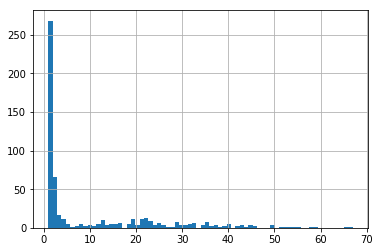

In [37]:
mask = log.key.str.len() > 1
mask &= log.lev_dist == 0

log.loc[mask].participant_id.value_counts().hist(bins=70)

#### Overly broad completion condition

 Because the condition for completion is only that lev_dist == len_diff, then even if a letter is inserted into the middle of the word, this is considered a completion. For example, in the conjunction case: I-l-l becomes I'll. Or g-u-l-t-y becomes guilty. The former case can be argued to be a completion, but the latter is definitely not.

#### Overly strict prediction vs. correction classificaiton

Fuzziness between completion and correction subtypes ('ite2'). If somebody types 'g-i-u-l' and then completes to 'guilty', that's a completion. But currently we mark it as a correction because of the substitution between 'i-u' and 'u-i'.

#### Incorrect Levenshtein distance

Sometimes the Levenshtein distances appears to be incorrect. So far, this only seems to happen in the case of a backspace, where instead of 1, the Levenshtein distance is calculated as zero.

In [133]:
log.loc[log.ts_id == 68218].iloc[25:35]

,ts_id,entry_id,key,lev_dist,text_field,len_diff,iki,text_field_prev,is_rep,ite,is_forward,participant_id,iki_norm,ite2
79507,68218,6.0,h,1,Liverpool always h,1,459.0,Liverpool always,False,none,True,19771,459.0,NA
79508,68218,6.0,a,1,Liverpool always ha,1,85.0,Liverpool always h,False,none,True,19771,85.0,NA
79509,68218,6.0,s,1,Liverpool always has,1,154.0,Liverpool always ha,False,none,True,19771,154.0,NA
79510,68218,-1.0,,2,Liverpool always has,1,82.0,Liverpool always has,False,none,True,19771,82.0,NA
79511,68218,-2.0,_,0,Liverpool always has,-1,654.0,Liverpool always has,False,none,True,19771,654.0,NA
79512,68218,-3.0,_,1,Liverpool always ha,-1,133.0,Liverpool always has,False,none,False,19771,133.0,NA
79513,68218,9.0,d,1,Liverpool always had,1,203.0,Liverpool always ha,False,none,True,19771,203.0,NA
79514,68218,-1.0,,1,Liverpool always had,1,116.0,Liverpool always had,False,none,True,19771,116.0,NA
79515,68218,10.0,a,1,Liverpool always had a,1,143.0,Liverpool always had,False,none,True,19771,143.0,NA
79516,68218,-1.0,,1,Liverpool always had a,1,78.0,Liverpool always had a,False,none,True,19771,78.0,NA


#### Backspaces at the end of the text input

Backspaces at the end of the text input are considered as "entry separators". If a user types a word and then hits backspace and then continues to type the same word, this is considered as two separate entries. This means that if we would have a bunch of nonsensical entries. For example, a user types g-i-u, then backspaces twice, and then types u-i-l-t-y. Independently, both entries don't make much sense.

In [136]:
log.loc[log.ts_id == 3091].iloc[10:25]

,ts_id,entry_id,key,lev_dist,text_field,len_diff,iki,text_field_prev,is_rep,ite,is_forward,participant_id,iki_norm,ite2
10,3091,-1.0,,1,freak said,1,159.0,freak said,False,none,True,790,159.0,NA
11,3091,1.0,c,1,freak said c,1,434.0,freak said,False,none,True,790,434.0,NA
12,3091,1.0,h,1,freak said ch,1,94.0,freak said c,False,none,True,790,94.0,NA
13,3091,1.0,e,1,freak said che,1,340.0,freak said ch,False,none,True,790,340.0,NA
14,3091,1.0,e,1,freak said chee,1,177.0,freak said che,False,none,True,790,177.0,NA
15,3091,-3.0,_,1,freak said che,-1,357.0,freak said chee,False,none,False,790,357.0,NA
16,3091,2.0,e,1,freak said chee,1,146.0,freak said che,False,none,True,790,146.0,NA
17,3091,2.0,r,1,freak said cheer,1,351.0,freak said chee,False,none,True,790,351.0,NA
18,3091,-3.0,_,1,freak said chee,-1,104.0,freak said cheer,False,none,False,790,104.0,NA
19,3091,3.0,r,1,freak said cheer,1,228.0,freak said chee,False,none,True,790,228.0,NA


In [43]:
mask = log.entry_id == -3
mask &= (log.text_field + log.key.shift(1) == log.text_field_prev)
log.loc[mask].shape

(24933, 14)

In [55]:
mask = log.key == '_'
mask &= (log.text_field == log.text_field_prev.str[:-1])
log.loc[mask].shape

(55466, 14)

In [ ]:
mask

In [58]:
log.loc[log.key =='_'].shape

(57669, 14)

In [61]:
log.a

0          1.0
1          2.0
2          3.0
3          4.0
4          5.0
5          6.0
6          7.0
7          8.0
8          9.0
9         10.0
10        11.0
11        12.0
12        13.0
13        14.0
14        15.0
15        16.0
16         1.0
17         2.0
18         3.0
19         4.0
20         5.0
21         6.0
22         7.0
23         8.0
24         9.0
25        10.0
26        11.0
27        12.0
28        13.0
29        14.0
          ... 
905890    17.0
905891    18.0
905892    19.0
905893    20.0
905894    21.0
905895    22.0
905896    23.0
905897    24.0
905898    25.0
905899    26.0
905900    27.0
905901    28.0
905902    29.0
905903    30.0
905904    31.0
905905    32.0
905906    33.0
905907    34.0
905908    35.0
905909    36.0
905910    37.0
905911    38.0
905912    39.0
905913    40.0
905914    41.0
905915    42.0
905916    43.0
905917    44.0
905918    45.0
905919    45.0
Name: is_forward, Length: 905920, dtype: float64

In [57]:
log.loc[315:330]

,ts_id,entry_id,key,lev_dist,text_field,participant_id,len_diff,iki,text_field_prev,is_rep,ite,is_forward,iki_norm,ite2
315,5538,2.0,o,1,be back tommowo,1679,1,80.0,be back tommow,False,none,True,80.000000,NA
316,5538,2.0,r,1,be back tommowor,1679,1,245.0,be back tommowo,False,none,True,245.000000,NA
317,5538,3.0,to wood,4,be back to wood,1679,-1,137.0,be back tommowor,False,none,True,19.571429,NA
318,5538,-1.0,,1,be back to wood,1679,1,13.0,be back to wood,False,none,True,13.000000,NA
319,5538,-3.0,_,1,be back to wood,1679,-1,955.0,be back to wood,False,none,False,955.000000,NA
320,5538,-3.0,_,1,be back to woo,1679,-1,141.0,be back to wood,False,none,False,141.000000,NA
321,5538,-3.0,_,1,be back to wo,1679,-1,164.0,be back to woo,False,none,False,164.000000,NA
322,5538,-3.0,_,1,be back to w,1679,-1,132.0,be back to wo,False,none,False,132.000000,NA
323,5538,-3.0,_,1,be back to,1679,-1,152.0,be back to w,False,none,False,152.000000,NA
324,5538,-3.0,_,1,be back to,1679,-1,119.0,be back to,False,none,False,119.000000,NA
